In [3]:
import numpy as np
import qutip as qt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.circuit.library import QFT
from random import randint
import matplotlib.pyplot as plt
from time import time


from tools.classical import *
from tools.quantum import *
from boltzmann import *

In [11]:
np.random.randint(0, 3)

0

In [10]:
decimal_time_labels = list(range(2**(6 - 1)))
decimal_time_labels.extend(list(range(- 2**(6 - 1), 0)))

N_labels = np.arange(2**6 / 2, dtype=int)
N_labels_neg = np.arange(- 2**6 / 2, 0, dtype=int)
N_labels = np.concatenate((N_labels, N_labels_neg))
print(N_labels)
decimal_time_labels

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31 -32 -31 -30 -29
 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11
 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1]


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 -32,
 -31,
 -30,
 -29,
 -28,
 -27,
 -26,
 -25,
 -24,
 -23,
 -22,
 -21,
 -20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1]

In [40]:
spectrum = np.array([-4,    -2, -1.3, -0.1,     1,  2.1,     2.8895,  4])
eps = 0.1
signed = False
"""Rescale and shift to get spectrum in [0, 1] or [0, 1 - eps]
"""
# eigenenergies = np.linalg.eigvalsh(hamiltonian)
# smallest_eigval = np.round(eigenenergies[0])
smallest_eigval = spectrum[0]
# largest_eigval = np.round(eigenenergies[-1])
largest_eigval = spectrum[-1]

# Rescaling factor and shift for [-0.5, 0.5]
rescaling_factor = largest_eigval - smallest_eigval
if eps == 0:
    shift = -(largest_eigval + smallest_eigval) / (2 * rescaling_factor)
    
if eps != 0:
    rescaling_factor *= 2/ (1 - eps) # [-0.5, 0.5 - eps]
    shift = - (largest_eigval - smallest_eigval * eps) / (2 * (largest_eigval - smallest_eigval))
# Centre spectrum around 0: 

if signed == False:  # shift to [0, 1]
    shift += 0.5

rescaled_spectrum = (spectrum) / rescaling_factor + shift
rescaled_spectrum

array([0.        , 0.1125    , 0.151875  , 0.219375  , 0.28125   ,
       0.343125  , 0.38753437, 0.45      ])

In [134]:
num_qubits = 4
num_ancillas = 2
qr_sys = QuantumRegister(num_qubits, 'sys')
qr_anc = QuantumRegister(num_ancillas, 'anc')

# np.random.seed(666)
randstate_better = np.zeros(2**(num_qubits))
randstate_better[np.random.choice(2**num_qubits, 2**num_qubits//2, replace=False)] = 1
randstate_better /= np.linalg.norm(randstate_better)

circ = QuantumCircuit(qr_anc, qr_sys)
# random circuit
circ.initialize(randstate_better, qr_sys)

statevector = Statevector(circ).data

dm = DensityMatrix(circ)

I = qt.qeye(2)
X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()

tensor_list = pad_term([X, X], num_qubits=num_qubits, position=1)
print(list(range(num_qubits+ num_ancillas))[num_ancillas:])
print(list(range(num_ancillas, num_qubits+ num_ancillas)))

op = (qt.tensor(tensor_list).full())
padded_op = qt.tensor([qt.Qobj(op), qt.qeye(2**num_ancillas)])
expval_qiskit_dm = dm.expectation_value(op, list(range(num_qubits+ num_ancillas))[num_ancillas:])
expval = statevector.conj().T @ padded_op.full() @ statevector
print('Qiskit DM:', expval_qiskit_dm)
print('Statevector:', expval)

sys_dm = partial_trace(dm, [0, 1])
expval_from_partial_dm = np.trace(sys_dm.data @ op)
print('Partial trace:', expval_from_partial_dm)

another_expval_from_partial_dm = sys_dm.expectation_value(op)
print('Another partial trace:', another_expval_from_partial_dm)

[2, 3, 4, 5]
[2, 3, 4, 5]
Qiskit DM: (0.2499999999999998+0j)
Statevector: (0.24999999999999994+0j)
Partial trace: (0.24999999999999978+0j)
Another partial trace: (0.24999999999999978+0j)


In [7]:
num_energy_bits = 6
num_qubits = 3
zerozero = np.array([[1, 0], [0, 0]])
padded_zerozero = np.kron(np.eye(2**num_qubits), zerozero)
padded_zerozero = np.kron(padded_zerozero, np.eye(2**num_energy_bits))
padded_zerozero

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
padded_tensor_list = [qt.Qobj(np.eye(2**num_qubits)), qt.Qobj(zerozero), qt.Qobj(np.eye(2**num_energy_bits))]
qt_padded = qt.tensor(padded_tensor_list)

dist = np.linalg.norm(qt_padded.full() - padded_zerozero)
dist

0.0

In [23]:
num_qubits = 5
coeffs = [1.5, 1.2, 0.6, 0.9]
theta = np.pi / (-0.5)

inverse_trotter_step_circ = inverse_trotter_step_heisenberg(num_qubits, coeffs, symbreak=True)
trotter_step_circ = trotter_step_heisenberg(num_qubits, coeffs, symbreak=True)
# inverse_trotter_step_circ.assign_parameters([-theta], inplace=True)
# trotter_step_circ.assign_parameters([theta], inplace=True)
# prev_inverse_trotter_step_circ = trotter_step_heisenberg(num_qubits, coeffs, symbreak=True)
# prev_inverse_trotter_step_circ.assign_parameters([-theta], inplace=True)

# prev_inverse_op = Operator(prev_inverse_trotter_step_circ)
# inverse_op = Operator(inverse_trotter_step_circ)
# op = Operator(trotter_step_circ)

# distance_to_id = np.linalg.norm(op.data @ inverse_op.data - np.eye(2**num_qubits))
# print(f'Distance with inverse Trotter: {distance_to_id}')
# distance_to_id_prev = np.linalg.norm(op.data @ prev_inverse_op.data - np.eye(2**num_qubits))
# print(f'Distance prev: {distance_to_id_prev}')


In [24]:
num_trotter_steps = 10
T = 1
total_time = 2 * np.pi * T
U = ham_evol(num_qubits, trotter_step=trotter_step_circ, num_trotter_steps=num_trotter_steps, time=total_time)
U_dag = ham_evol(num_qubits, trotter_step=inverse_trotter_step_circ, num_trotter_steps=num_trotter_steps, time=-total_time)
U_op = Operator(U)
U_dag_op = Operator(U_dag)

In [26]:
dist_to_id_evol = np.linalg.norm(U_op.data @ U_dag_op.data - np.eye(2**num_qubits))
print(f'Distance with evolution: {dist_to_id_evol}')

Distance with evolution: 3.2289662155096717e-14


In [5]:
num_energy_bits = 6
cr_energy = ClassicalRegister(num_energy_bits, name='cr_energy')
cr_boltzmann = ClassicalRegister(1, name='cr_boltz')
bithandler = BitHandler([cr_energy, cr_boltzmann])

counts = {'100100 1': 471, '111100 1': 216, '111101 1': 136, '100101 1': 130, '100011 1': 42, '111011 1': 3, '101011 1': 1, '101010 1': 1}
bithandler.measured_counts = counts
energy_counts = bithandler.get_counts_for_creg(cr_energy)
print(energy_counts)
boltzmann_counts = bithandler.get_counts_for_creg(cr_boltzmann)
print(boltzmann_counts)
# phase_bits = list(energy_counts.keys())[0] # take the most often obtaned result
# phase_bits_shots = energy_counts[phase_bits]

{'001001': 471, '111001': 216, '111011': 136, '001011': 130, '000111': 42, '110111': 3, '010111': 1, '010101': 1}
{'1': 1000}


In [3]:
num_energy_bits = 4
cr_energy = ClassicalRegister(num_energy_bits, name='w')
cr_boltzmann = ClassicalRegister(1, name='b')
bithandler = BitHandler([cr_boltzmann, cr_energy])

counts = {'1010 0': 298, '1001 1': 212, '1111 1': 177, '0000 0': 108, '1010 1': 62, '1011 0': 20, '1111 0': 19}
bithandler.measured_counts = counts
counts_for_energy = bithandler.get_counts_for_crreg(cr_energy)
print(counts_for_energy)

{'1010': 360, '1001': 212, '1111': 196, '0000': 108, '1011': 20}


In [17]:
num_qubits = 5
X_qt = qt.sigmax()
Y_qt = qt.sigmay()
Z_qt = qt.sigmaz()
coeffs = [1, 1, 1, 1]
hamiltonian_qt = hamiltonian_matrix([X_qt, X_qt], [Y_qt, Y_qt], [Z_qt, Z_qt], coeffs=coeffs, num_qubits=num_qubits, symbreak_term=[Z_qt])
spectrum, eigenstates = np.linalg.eigh(hamiltonian_qt)
print(f'Coeffs used: {coeffs} for spectrum {spectrum}')
eig_index = 10
eigenstate = eigenstates[:, eig_index]  #! 
exact_energy = spectrum[eig_index]
print(f'Energy to predict {exact_energy}')

expval = eigenstate.conj().T @ hamiltonian_qt @ eigenstate
print(expval)

expval_qt = qt.expect(qt.Qobj(hamiltonian_qt), qt.Qobj(eigenstate))
print(expval_qt)



Coeffs used: [1, 1, 1, 1] for spectrum [-8.41480675e+00 -8.01149686e+00 -7.45710970e+00 -6.56278848e+00
 -4.82842712e+00 -3.76446278e+00 -3.46410162e+00 -3.10903996e+00
 -2.56016642e+00 -2.48908833e+00 -1.72700584e+00 -1.54375254e+00
 -1.12310563e+00 -3.68457240e-01 -7.30967063e-16 -6.65773340e-16
  8.28427125e-01  9.50705136e-01  1.02497194e+00  1.68545843e+00
  1.85582806e+00  2.00000000e+00  2.57314158e+00  3.08156908e+00
  3.46410162e+00  3.87693371e+00  4.00000000e+00  4.00000000e+00
  4.84875524e+00  6.11081172e+00  7.12310563e+00  8.00000000e+00]
Energy to predict -1.727005838385661
[[-1.72700584+0.j]]
-1.7270058383856617


In [15]:
import numpy as np

# Define two matrices A and B
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
a = np.array([[1, 0], [0, 1]])
b = a

# Compute the Kronecker product
result = np.kron(A, B)
res = np.kron(a, b)
result2 = np.tensordot(A, B, axes=0)
res2 = np.tensordot(a, b, axes=0)

# Compute the tensor product using np.einsum
result3 = np.einsum('ij,kl->ikjl', A, B).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
res3 = np.einsum('ij,kl->ikjl', a, b).reshape(a.shape[0] * b.shape[0], a.shape[1] * b.shape[1])
print(result)
# print(result2.reshape(4, 4))
print(result3)

print(res)
# print(res2.reshape(4, 4))
print(res3)

[[ 5  6 10 12]
 [ 7  8 14 16]
 [15 18 20 24]
 [21 24 28 32]]
[[ 5  6 10 12]
 [ 7  8 14 16]
 [15 18 20 24]
 [21 24 28 32]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [5]:
circ = QuantumCircuit(3)
circ.h(range(3))
circ.global_phase = 2
big_circ = QuantumCircuit(4)
big_circ.compose(circ, range(3), inplace=True)

print(big_circ)

add_phase = [[]]

global phase: 2
     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘
q_3: ─────
          


In [18]:
bin(-5)

'-0b101'

In [4]:
X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()

num_qubits = 5
H = hamiltonian_matrix([X, X], [Y, Y], [Z, Z], [X, Z, Z], num_qubits=num_qubits)
eigvals = np.linalg.eigvalsh(H)
print(eigvals)
shifted_H = shift_spectrum(H)
shifted_eigvals = np.linalg.eigvalsh(shifted_H)
print(shifted_eigvals)

print(np.isclose(eigvals + np.abs(eigvals[0]), shifted_eigvals))

qr0 = QuantumRegister(1, 'qr0')
qr1 = QuantumRegister(2, 'qr1')
qrsys = QuantumRegister(num_qubits, 'sys')
qr3 = QuantumRegister(4, 'q3')
qr_r = QuantumRegister(3, 'qr_r')

circ = QuantumCircuit(qrsys)
qr_index = circ.qregs.index(qrsys)
print(qr_index)

print(circ.qregs)


energy = energy_from_full_state(circ, H, subspace_qubits=[qrsys], qr_index=qr_index)
energy

[-9.11961148e+00 -9.11961148e+00 -6.47213595e+00 -6.47213595e+00
 -4.47213595e+00 -4.47213595e+00 -4.38516481e+00 -3.33653707e+00
 -3.33653707e+00 -3.23606798e+00 -3.23606798e+00 -2.60555128e+00
 -1.00895946e-15 -3.40718886e-16  6.80517146e-16  9.91538347e-16
  1.23606798e+00  1.23606798e+00  2.47213595e+00  2.47213595e+00
  2.57260505e+00  2.57260505e+00  2.76393202e+00  2.76393202e+00
  3.88354350e+00  3.88354350e+00  4.47213595e+00  4.47213595e+00
  4.60555128e+00  6.38516481e+00  7.23606798e+00  7.23606798e+00]
[-1.47665609e-06 -1.47665607e-06  2.64747405e+00  2.64747405e+00
  4.64747405e+00  4.64747405e+00  4.73444519e+00  5.78307293e+00
  5.78307293e+00  5.88354202e+00  5.88354202e+00  6.51405872e+00
  9.11961000e+00  9.11961000e+00  9.11961000e+00  9.11961000e+00
  1.03556780e+01  1.03556780e+01  1.15917460e+01  1.15917460e+01
  1.16922151e+01  1.16922151e+01  1.18835420e+01  1.18835420e+01
  1.30031535e+01  1.30031535e+01  1.35917460e+01  1.35917460e+01
  1.37251613e+01  1.5504

5.0

In [4]:
full_obs = qt.qeye(1)
full_obs = qt.tensor([full_obs, qt.qeye(2)])
print(full_obs)

Quantum object: dims = [[1, 2], [1, 2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]


[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, -8, -7, -6, -5, -4, -3, -2, -1]
[9.58758528e-01 2.00966705e-01 1.85083937e-03 7.48933209e-07
 1.33151846e-11 1.04011424e-17 3.56980615e-25 5.38316844e-34
 3.56665457e-44 5.38316844e-34 3.56980615e-25 1.04011424e-17
 1.33151846e-11 7.48933209e-07 1.85083937e-03 2.00966705e-01]


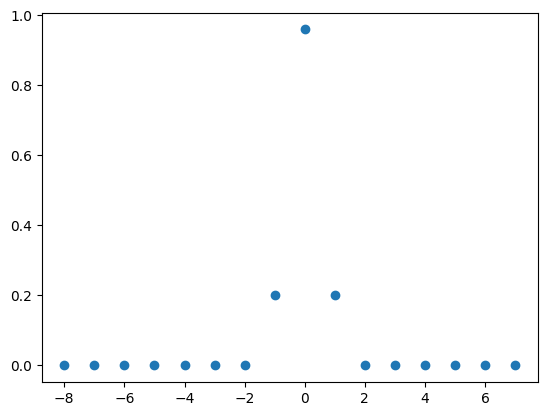

In [2]:
num_energy_bits = 4
sigma = num_energy_bits / 10
decimal_time_labels = list(range(- 2 ** (num_energy_bits - 1), 2 ** (num_energy_bits - 1)))
print(decimal_time_labels)

decimal_time_labels2 = list(range(2**(num_energy_bits - 1)))
decimal_time_labels2.extend(list(range(- 2**(num_energy_bits - 1), 0)))
print(decimal_time_labels2)

gauss_amplitude = lambda decimal_time: np.exp(-(decimal_time ** 2) / (4 * sigma ** 2))
amplitudes = [gauss_amplitude(decimal_time) for decimal_time in decimal_time_labels]
amplitudes /= np.linalg.norm(amplitudes)
amplitudes2 = [gauss_amplitude(decimal_time) for decimal_time in decimal_time_labels2]
amplitudes2 /= np.linalg.norm(amplitudes2)
print(amplitudes2)
# plot amplitudes, amplitudes2 as dots
# plt.scatter(decimal_time_labels, amplitudes)
plt.scatter(decimal_time_labels2, amplitudes2)

